# import modules

In [5]:
import keras
from keras.utils import plot_model,to_categorical
from keras.layers import Dense,LSTM,Bidirectional,TimeDistributed,Conv1D,MaxPool1D,Concatenate,Dropout,BatchNormalization,Add
from keras import Model,Input
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
import keras
from keras.utils import plot_model,to_categorical
from keras import Model,Input
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
import tensorflow as tf
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model


from attention_utils import get_activations
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np

# Load Features

In [17]:
X_features=np.load('./feature/X_feature.npy')
y=np.load('./feature/y_initial.npy')

In [18]:
X_features.shape

(4704, 50, 57)

In [19]:
y.shape

(4704, 2)

In [20]:
y[0]

array(['1', '0'], dtype='<U2')

In [21]:
alphabet_set={'0': 0,'b': 1, 'c': 2,'d': 3,'f': 4,'g': 5,'h': 6,'j': 7,'k': 8,'l': 9, 'm': 10,'n': 11,'p': 12,'q': 13,
          'r': 14,'s': 15,'t': 16,'w': 17,'x': 18,'y': 19,'z': 20}

In [22]:
alphabet_set={value:key for key,value in alphabet_set.items()}

## One-hot Encoding

In [23]:
y=to_categorical(y,num_classes=21)

In [24]:
y.shape

(4704, 2, 21)

## split train and test

In [25]:
X_train, X_test, y_train, y_test=train_test_split(X_features,y,test_size=0.1,random_state=2019)

In [26]:
X_train.shape,X_test.shape

((4233, 50, 57), (471, 50, 57))

In [27]:
y_train.shape,y_test.shape

((4233, 2, 21), (471, 2, 21))

# Models


In [6]:
NUM_CLASSES=21
BATCH_SIZE=128
EPOCHS=100
MODEL_SAVE_PATH='./models/initial_cnn.h5'

In [96]:
def residual_block(x, filters, conv_num, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)

In [76]:
def build_model():
    inputs = Input(shape=(50, 57))
    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = MaxPool1D(pool_size=3, strides=2)(x)
    output = Dense(21, activation='relu')(x)
    model = Model(inputs=[inputs], outputs=output)
    return model


In [77]:
model = build_model()
model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 50, 57)]     0                                            
__________________________________________________________________________________________________
conv1d_165 (Conv1D)             (None, 50, 16)       2752        input_19[0][0]                   
__________________________________________________________________________________________________
activation_113 (Activation)     (None, 50, 16)       0           conv1d_165[0][0]                 
__________________________________________________________________________________________________
conv1d_166 (Conv1D)             (None, 50, 16)       784         activation_113[0][0]             
______________________________________________________________________________________

In [7]:
def build_model(input_shape, NUM_CLASSES):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

In [8]:
model = build_model((50,57), NUM_CLASSES)

NameError: name 'residual_block' is not defined

In [9]:
# main
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # 乘上了attention权重，但是并没有求和，好像影响不大
    # 如果分类任务，进行Flatten展开就可以了
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def attention_model():
    inputs = Input(shape=(50, 57))

    x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    x = Dropout(0.3)(x)

    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = MaxPool1D(pool_size=47, strides=2)(attention_mul)

    output = Dense(21, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [10]:
model = attention_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 57)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 50, 64)       3712        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 50, 64)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 50, 128)      66048       dropout[0][0]                    
_______________________________________________________________________________________

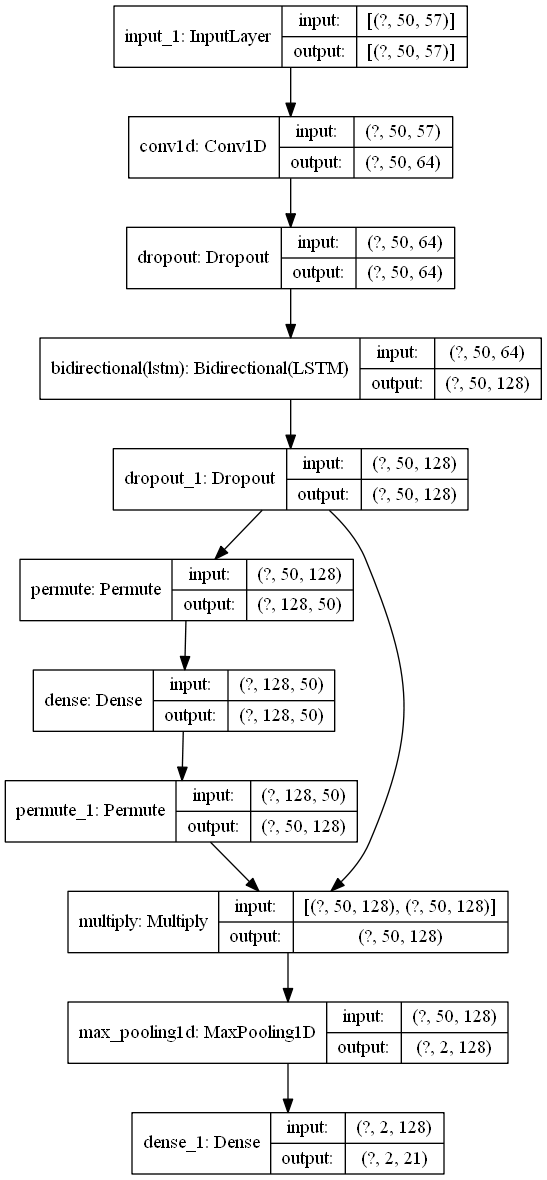

In [13]:
import pydotplus
import graphviz 
from keras.utils import plot_model
plot_model(model, to_file='.\\audio_initial.png',show_shapes=True)

In [ ]:
Input(shape=(50,57))
def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

In [15]:
K.clear_session()
inputs=Input(shape=(50,57))
x_1=Conv1D(filters=64,kernel_size=3,padding='same')(inputs)
x_1=MaxPool1D()(x_1)
x_2=Conv1D(filters=128,kernel_size=8,padding='same')(inputs)
x_2=MaxPool1D()(x_2)
x_3=Conv1D(filters=256,kernel_size=13,padding='same')(inputs)
x_3=MaxPool1D()(x_3)
x_4=Conv1D(filters=256,kernel_size=18,padding='same')(inputs)
x_4=MaxPool1D()(x_4)
x_5=Conv1D(filters=256,kernel_size=25,padding='same')(inputs)
x_5=MaxPool1D()(x_5)
x=Concatenate()([x_1,x_2,x_3,x_4,x_5])
x=BatchNormalization()(x)
x=Conv1D(filters=64,kernel_size=21)(x)
x=MaxPool1D()(x)
x=Dropout(0.25)(x)
x=TimeDistributed(Dense(NUM_CLASSES,activation='softmax'))(x)
model=Model(inputs=inputs,outputs=x)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 57)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 50, 64)       11008       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 128)      58496       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 50, 256)      189952      input_1[0][0]                    
_______________________________________________________________________________________

In [31]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
plot_model(model,'model_initial.jpg',show_shapes=True)
lr_reduce=kcallbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=6,verbose=1,min_lr=0.00001)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_accuracy',verbose=1,save_best_only=True)
callback_list=[save_model,lr_reduce]
history=model.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_test,y_test),
                  callbacks=callback_list)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/100
33/34 [============================>.] - ETA: 0s - loss: 2.9136 - accuracy: 0.3858
Epoch 00001: val_accuracy improved from -inf to 0.43312, saving model to ./models\initial_cnn.h5
34/34 [==============================] - 3s 87ms/step - loss: 2.9130 - accuracy: 0.3860 - val_loss: 2.7126 - val_accuracy: 0.4331
Epoch 2/100
33/34 [============================>.] - ETA: 0s - loss: 2.4797 - accuracy: 0.4388
Epoch 00002: val_accuracy did not improve from 0.43312
34/34 [==============================] - 2s 62ms/step - loss: 2.4795 - accuracy: 0.4387 - val_loss: 2.4191 - val_accuracy: 0.4331
Epoch 3/100
33/34 [============================>.] - ETA: 0s - loss: 2.3358 - accuracy: 0.4388
Epoch 00003: val_accuracy did not improve from 0.43312
34/34 [==============================] - 2s 64ms/step - loss: 2.3356 - accuracy: 0.4387 - val_loss: 

## plot_curve

In [32]:
from help import plot_curve,plot_curve_with_smooth

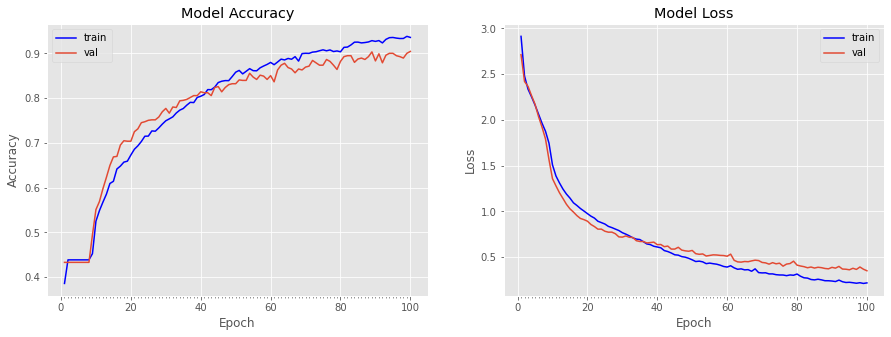

In [33]:
plot_curve(history)

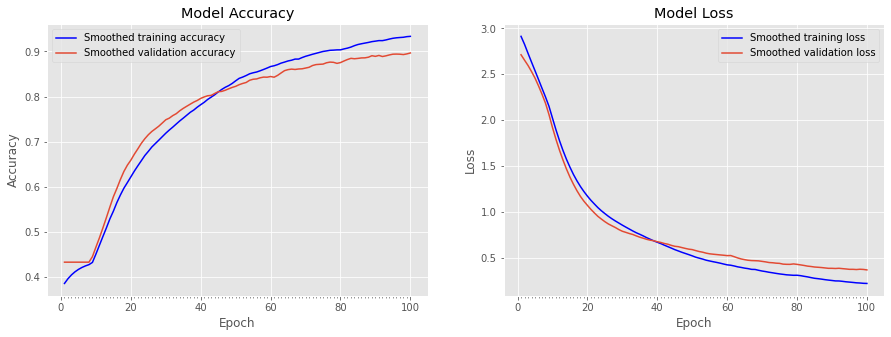

In [34]:
plot_curve_with_smooth(history)

## confusion_metrix

In [30]:
# model.load_weights('./models/initial_cnn.h5')

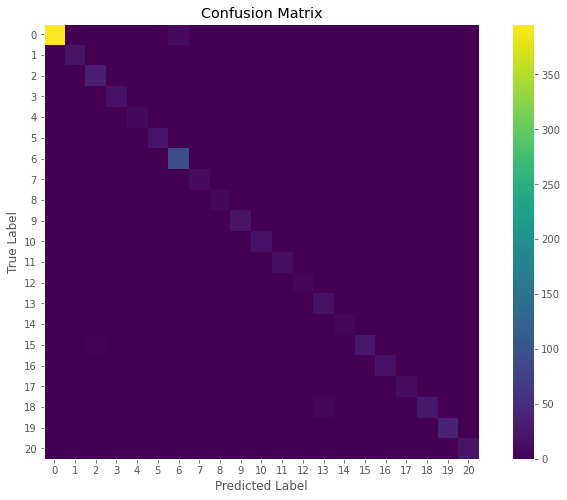

In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred,axis=-1).ravel()
y_true=np.argmax(y_test,axis=-1).ravel()
con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
def plot_confusion_matrix(confusion_mat):
    plt.figure(figsize=(12,8))
    plt.imshow(confusion_mat)
    plt.title('Confusion Matrix')
    plt.colorbar()
    labels = list(range(0,21))
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(False)
    plt.show() 
plot_confusion_matrix(con_matrix)

## classfication_report

In [36]:
from sklearn.metrics import classification_report
#model.load_weights('./models/initial_cnn.h5')

In [14]:
target_names=[alphabet_set[i] for i in range(21)]
print(classification_report(y_true,y_pred,digits=4,labels=list(range(21)),target_names=target_names))

NameError: name 'alphabet_set' is not defined

# predict test

In [34]:
import librosa
import sklearn
def get_mfcc_feature(path,maxlen=50):
    x, sr = librosa.load(path)
    # extract mfcc
    mfcc = librosa.feature.mfcc(x, sr=sr)
    # Center to the mean and component wise scale to unit variance
    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    mfcc_diff = np.diff(mfcc, axis=0)
    mfcc_diff_diff = np.diff(mfcc_diff, axis=0)
    # concatenate mfcc,mfcc_diff and mfcc_diff_diff
    mfccs = np.concatenate([mfcc, mfcc_diff, mfcc_diff_diff], axis=0).T
    #pad the mfccs_feature
    if mfccs.shape[0]<maxlen:
        mfccs=np.concatenate([mfccs,np.zeros((maxlen-mfccs.shape[0],57))],axis=0)
    return mfccs

In [35]:
wav_file='./voice_data/person10_time1_group4_mao_2.wav'
test=get_mfcc_feature(path=wav_file)
test=np.expand_dims(test,axis=0)
pred=model.predict(test)
pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

Predict Label:m


In [36]:
wav_file='./voice_data/person10_time1_group4_zou_3.wav'
test=get_mfcc_feature(path=wav_file)
test=np.expand_dims(test,axis=0)
pred=model.predict(test)
pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

Predict Label:z


In [37]:
wav_file='./voice_data/person10_time1_group3_chu_1.wav'
test=get_mfcc_feature(path=wav_file)
test=np.expand_dims(test,axis=0)
pred=model.predict(test)
pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

Predict Label:c
